# save Eulerian data at positions of synthetic float data for mapping as netcdf
#
# Note: Here, take one of the files created with the other scripts* and extract corresponding data from monthly mean output
#    *either co-located with bgcArgo or subsampled from all E3SM float
# 
# HERE: variables that don't have a depth dimension (pCO2, air-sea flux etc)
#

In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import glob
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from numba import njit
import time
from statsmodels.stats.weightstats import DescrStatsW
from tqdm import tqdm
from math import radians, degrees, sin, cos, asin, acos, sqrt
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import interpolate
from netCDF4 import Dataset, MFDataset
import dask


In [2]:
#---
# some settings & load float data set with positions/times for which Eulerian output should be extracted
#---

# where to store final file with Eulerian obs (offline subsampling)?
savepath = '/global/cfs/cdirs/m4003/cnissen/floats/test_data_for_mapping/'

# select an input file --> these data points will be extracted from Eulerian fields
path_floats = '/global/cfs/cdirs/m4003/cnissen/floats/test_data_for_mapping/'

# ARGO
#file_floats = 'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc'
#file_floats = 'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc'
#file_floats = 'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_50S_corr_2D_fields.nc'

#SOCAT
#file_floats = 'floats_years_2009_2018_pCO2surface_ifrac_CO2_gas_flux_colocated_with_SOCAT_south_of_40S_corr_2D_fields.nc'
#file_floats = 'floats_years_2009_2018_pCO2surface_ifrac_CO2_gas_flux_colocated_with_SOCAT_south_of_30S_corr_2D_fields.nc'
file_floats = 'floats_years_2004_2023_pCO2surface_ifrac_CO2_gas_flux_colocated_with_SOCAT_south_of_40S_corr_2D_fields.nc'

#file_floats = 'floats_years_2009_2018_pCO2surface_ifrac_CO2_gas_flux_colocated_with_bgcArgo_south_of_30S_corr_2D_fields.nc' # 
#file_floats = 'floats_years_2009_2018_pCO2surface_ifrac_CO2_gas_flux_colocated_with_bgcArgo_south_of_40S_corr_2D_fields.nc' # 

#file_floats = 'floats_years_2004_2023_pCO2surface_ifrac_CO2_gas_flux_colocated_with_bgcArgo_south_of_30S_corr_2D_fields.nc'
#file_floats = 'floats_years_2004_2023_pCO2surface_ifrac_CO2_gas_flux_colocated_with_bgcArgo_south_of_40S_corr_2D_fields.nc'

#file_floats = 'floats_years_2009_2018_temperature_salinity_oxygen_colocated_with_bgcArgo_south_of_40S_corr.nc' # 
#file_floats = 'floats_years_2009_2018_temperature_salinity_oxygen_colocated_with_bgcArgo_south_of_30S_corr.nc' # 

print(file_floats)

# what year do the data start in?
year_start = 2004 #2009
year_end   = 2023 #2018

# choose mesh of Eulerian output
which_mesh = 'regridded' # regridded (1x1 degree) or native

# load lat/lon/time of float data
ff = xr.open_dataset(path_floats+file_floats)
lon  = ff['lon'].values
lat  = ff['lat'].values
time = ff['time'].values
depth_target = ff['pressure'].values
if file_floats in ['floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc',
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc',\
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_50S_corr_2D_fields.nc']: 
    temp = ff['SST'].values
    salt = ff['ifrac'].values 
    oxy  = ff['SSS'].values
else:
    temp = ff['pCO2surface'].values
    salt = ff['ifrac'].values 
    oxy  = ff['CO2_gas_flux'].values
ff.close()
    
print(lat.shape,lon.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('Target depths for extraction from Eulerian fields:',depth_target)


if file_floats in ['floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc',\
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc',\
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_50S_corr_2D_fields.nc']: 
    vari_temp = 'timeMonthly_avg_activeTracers_temperature'
    vari_salt = 'timeMonthly_avg_iceFraction' 
    vari_oxy  = 'timeMonthly_avg_activeTracers_salinity'
    # settings for writing the chosen variables into the final nc file
    vari1_nc = 'SST'
    vari2_nc = 'ifrac'
    vari3_nc = 'SSS'
    unit1    = 'deg C'
    unit2    = ''
    unit3    = 'g kg-1'
else:
    # settings for writing the chosen variables into the final nc file
    vari_temp = 'timeMonthly_avg_ecosys_diag_pCO2surface'
    vari_salt = 'timeMonthly_avg_iceFraction' # LATER: change to sea ice cover. I currently only have sea ice as daily avg!
    vari_oxy  = 'timeMonthly_avg_CO2_gas_flux'
    # settings for writing the chosen variables into the final nc file
    vari1_nc = 'pCO2surface'
    vari2_nc = 'timeMonthly_avg_iceFraction'
    vari3_nc = 'CO2_gas_flux'
    unit1    = 'ppmv'
    unit2    = ''
    unit3    = 'mmol C m^{-2} s^{-1}'

# STEPS:

# co-locate each lat/lon to the closest model grid cell

# convert time: get "months since start of sampling period" (for co-location with monthly Eulerian output)

# identify which data points need to be combined (same model grid cell & same time)
# --> average these (store number of data points going into each average) #--- LATER: also store min/max ----#

# extract the same locations/times from Eulerian model output #--- CHECK that this step is done correctly! ----#

#
# NOTE: I currently get unrealistically high deviations
#       are there some zeros or such that I should be masking??
#

floats_years_2004_2023_pCO2surface_ifrac_CO2_gas_flux_colocated_with_SOCAT_south_of_40S_corr_2D_fields.nc
(1471843,) (1471843,)
Min/Max lon: 0.032390715942219685 359.9944046838065
Min/Max lat: -78.63575784132023 -39.08812987872285
Target depths for extraction from Eulerian fields: [0.]


In [3]:
#---
# colocate in space
#---

#---
# read mesh info
#---

if which_mesh=='native':
    rad_to_deg = 180.0/np.pi
    path_mesh = '/global/cfs/cdirs/m4003/maltrud/southernOceanRefined/mesh/'
    meshfile = xr.open_dataset(path_mesh+'mpaso.SO12to60E2r5.20221118.nc')
    lon_mesh  = meshfile['lonCell'].values*rad_to_deg
    lat_mesh  = meshfile['latCell'].values*rad_to_deg
    #topo = meshfile['bottomDepth'].values
    #area = meshfile['areaCell'].values
    #zlevs            = meshfile['refBottomDepth'].values
    #layerThickness   = meshfile['layerThickness'].values
    #restingThickness = meshfile['restingThickness'].values
    meshfile.close()
elif which_mesh=='regridded':
    # create 1D vector of all ocean cells
    path_mesh = '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/'
    file1     = 'monthlyAverages.year2009all_O2_regridded.nc'
    meshfile = xr.open_dataset(path_mesh+file1)
    lon_mesh  = meshfile['lon'].values
    lat_mesh  = meshfile['lat'].values
    lon_mesh,lat_mesh = np.meshgrid(lon_mesh,lat_mesh) # create 2D array
    data_aux  = meshfile['timeMonthly_avg_ecosysTracers_O2'][0,0,:,:].values # to mask lat/lon, i.e., restrict to ocean cells
    lon_mesh[np.isnan(data_aux)] = np.nan
    lat_mesh[np.isnan(data_aux)] = np.nan
    lon_mesh = lon_mesh.ravel()
    lat_mesh = lat_mesh.ravel()
    ind_no_NaN_mesh = np.where(~np.isnan(lon_mesh))[0]
    print(lon_mesh.shape)
    print(ind_no_NaN_mesh.shape)
    lon_mesh = lon_mesh[~np.isnan(lon_mesh)]
    lat_mesh = lat_mesh[~np.isnan(lat_mesh)]
    ff.close()
    
print(len(lon_mesh),'nodes in mesh')
print('Min/Max lon:',np.min(lon_mesh),np.max(lon_mesh))
print('Min/Max lat:',np.min(lat_mesh),np.max(lat_mesh))
    

# convert to radians
lon_mesh_rad = np.asarray([radians(x) for x in lon_mesh]) 
lat_mesh_rad = np.asarray([radians(x) for x in lat_mesh])

#----
# function to find closest model grid cell
#----

@njit
def find_closest_grid_cell2(lon_point,lat_point,lon_model,lat_model,distance_list):
    # lon_model,lat_model should be 1D
    # all lat/lon will be converted to radians within this function
    for mm in range(0,len(lon_model)):
        #lon1, lat1, lon2, lat2 = map(radians, [lon_point, lat_point, lon_model[mm], lat_model[mm]])
        distance_list[mm] = 6371 * (acos(sin(lat_point) * sin(lat_model[mm]) + cos(lat_point) * cos(lat_model[mm]) * cos(lon_point - lon_model[mm])))
    return np.min(distance_list),np.argmin(distance_list)

#----
# loop over all points in float file and get closest node in SO mesh
#----

dist_thresh = 3 # restrict search radius for closest grid cell
closest_node_list = np.nan*np.ones_like(lon)
distance_list_all = np.nan*np.ones_like(lon)
print(closest_node_list.shape,distance_list_all.shape)
for pp in tqdm(range(0,len(lon))): # loop over all float points

    # restrict model cells to provide to function to speed things up
    # NOTE: due to the irregularity of the grid, only do this based on one dimension (either lat or lon)
    #       (else, I might not get matching indices for lat/lon)
    aux_ind_lat   = np.where((np.abs(lat_mesh-float(lat[pp]))<dist_thresh))
    distance_list = np.zeros(len(lat_mesh[aux_ind_lat]))
    closest_dist,index_closest  = find_closest_grid_cell2(radians(lon[pp]),radians(lat[pp]),\
                                                            lon_mesh_rad[aux_ind_lat],\
                                                                lat_mesh_rad[aux_ind_lat],distance_list)
   # print('closest_dist',closest_dist) #,index_closest)
    
    # convert index back to lat/lon indices of full mesh (this is what I need to supply to code)
    aux_lon,aux_lat = lon_mesh[aux_ind_lat][int(index_closest)],lat_mesh[aux_ind_lat][int(index_closest)]
  #  print(aux_lat,aux_lon)
    ind_full_grid = np.where((lat_mesh==aux_lat) & (lon_mesh==aux_lon))
    #print(lat_mesh[ind_full_grid][0],lon_mesh[ind_full_grid][0])
    #print(lat[pp],lon[pp])
    #print(ind_full_grid[0][0])
    #print()
    
    closest_node_list[pp] = ind_full_grid[0][0]
    distance_list_all[pp] = closest_dist
    
    del aux_lat,aux_lon,aux_ind_lat,distance_list,index_closest,closest_dist
    

(64800,)
(41671,)
41671 nodes in mesh
Min/Max lon: -179.5 179.5
Min/Max lat: -78.5 89.5
(1471843,) (1471843,)


100%|██████████| 1471843/1471843 [04:25<00:00, 5552.27it/s]


1471843
min/max distance: 0.0406762024856074 101.69041685066915


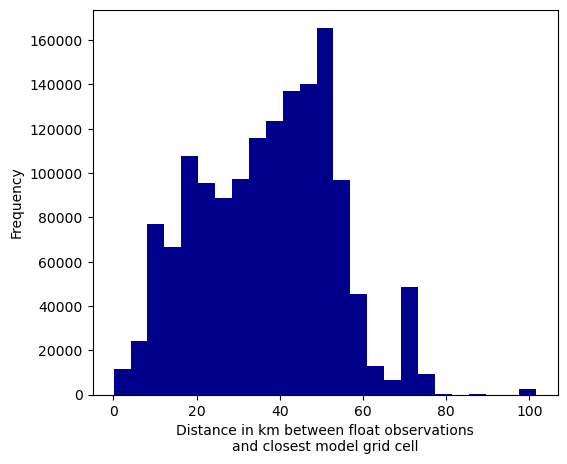

In [4]:
#---
# plot distribution of spatial distances between float observations and closest Eulerian grid cell
#---

print(len(distance_list_all))

print('min/max distance:',np.min(distance_list_all),np.max(distance_list_all))
fig = plt.figure(figsize=(6,5))
plt.hist(distance_list_all,bins=25,color='darkblue')
plt.xlabel('Distance in km between float observations\nand closest model grid cell')
plt.ylabel('Frequency')
plt.show()


In [5]:
#print(np.min(closest_node_list))
#print(lat_mesh[int(closest_node_list[120])])


#for mm in range(0,len(closest_node_list)):
#    if lat_mesh[int(closest_node_list[120])]>-30:
#        print('xxx')


In [6]:
#---
# convert time: get "months since start of sampling period" (for monthly Eulerian output)
#---
# "year_start" defines begin of sampling period in file (see above)

print(time) # ns

year_list  = np.nan*np.ones_like(lon)
month_list = np.nan*np.ones_like(lon)
day_list   = np.nan*np.ones_like(lon)
month_since_start_list = np.nan*np.ones_like(lon)
for tt in tqdm(range(0,len(lon))):
    aux = datetime.fromtimestamp(time[tt]/1e9) 
    #print('Year,month,day:',aux.year,aux.month,aux.day)
    
    year_list[tt]  = aux.year
    month_list[tt] = aux.month
    day_list[tt]   = aux.day
    
    #print('Months since start:',12*(aux.year-year_start)+aux.month)
    month_since_start_list[tt] = 12*(aux.year-year_start)+aux.month
    
    del aux

print('min/max month_since_start_list:',np.min(month_since_start_list),np.max(month_since_start_list))


[1.6067376e+18 1.6067376e+18 1.6067376e+18 ... 1.1697552e+18 1.1697696e+18
 1.1697696e+18]


100%|██████████| 1471843/1471843 [00:02<00:00, 651108.78it/s]

min/max month_since_start_list: 1.0 221.0


In [7]:
print(np.where(month_since_start_list==0)[0])
print(year_list[4164])
print(month_list[4164])
print(day_list[4164])

# Why is there a data point from 2008????

print(temp.shape)

[]
2020.0
12.0
13.0
(1, 1471843)


In [8]:
#-----
# identify which data points need to be combined (same model grid cell & same time)
#-----
# --> average these (store number of data points going into each average)

# combine data
data_combined = np.vstack((closest_node_list,month_since_start_list)).transpose()
print(data_combined.shape)

# get unique combinations of location (closest_node) and time (month_since_start)
aux_unique = np.unique(data_combined,axis=0)
print(aux_unique.shape)

data_avg_temp = np.nan*np.ones([temp.shape[0],aux_unique.shape[0]])
data_avg_salt = np.nan*np.ones([salt.shape[0],aux_unique.shape[0]])
data_avg_oxy  = np.nan*np.ones([oxy.shape[0],aux_unique.shape[0]])
# min
data_min_temp = np.nan*np.ones([temp.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_min_salt = np.nan*np.ones([salt.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_min_oxy  = np.nan*np.ones([oxy.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
# max
data_max_temp = np.nan*np.ones([temp.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_max_salt = np.nan*np.ones([salt.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_max_oxy  = np.nan*np.ones([oxy.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
# std
data_std_temp = np.nan*np.ones([temp.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_std_salt = np.nan*np.ones([salt.shape[0],aux_unique.shape[0]]) # only filled if more than one data point
data_std_oxy  = np.nan*np.ones([oxy.shape[0],aux_unique.shape[0]])  # only filled if more than one data point
num_data_points = np.nan*np.ones(aux_unique.shape[0])
for nn in tqdm(range(0,len(aux_unique))):
    node = int(aux_unique[nn,0])
    month_since = int(aux_unique[nn,1])
   # print('node,time:',node,month_since)
    
    # find all occurrences of this node/month combination
    ind = np.where((data_combined[:,0]==float(node)) & (data_combined[:,1]==float(month_since)))[0]
    aux = np.copy(data_combined[ind,0])
    ind_no_NaN = np.where(~np.isnan(aux))[0]
    #if ind.shape[0]>1:
    #    print(nn,ind.shape[0])
    #    print(ind)

   # print(np.nanmean(oxy[:,ind],axis=1)[0],oxy[0,ind])

    if ind[ind_no_NaN].shape[0]>0: # if any data left when ignoring NaNs
        #print(nn,ind[ind_no_NaN].shape[0])
        data_avg_temp[:,nn] = np.nanmean(temp[:,ind[ind_no_NaN]],axis=1)
        data_avg_salt[:,nn] = np.nanmean(salt[:,ind[ind_no_NaN]],axis=1)
        data_avg_oxy[:,nn]  = np.nanmean(oxy[:,ind[ind_no_NaN]],axis=1)
    if ind[ind_no_NaN].shape[0]>1:
        # std
        data_std_temp[:,nn] = np.nanstd(temp[:,ind[ind_no_NaN]],axis=1)
        data_std_salt[:,nn] = np.nanstd(salt[:,ind[ind_no_NaN]],axis=1)
        data_std_oxy[:,nn]  = np.nanstd(oxy[:,ind[ind_no_NaN]],axis=1)
        # min
        data_min_temp[:,nn] = np.nanmin(temp[:,ind[ind_no_NaN]],axis=1)
        data_min_salt[:,nn] = np.nanmin(salt[:,ind[ind_no_NaN]],axis=1)
        data_min_oxy[:,nn]  = np.nanmin(oxy[:,ind[ind_no_NaN]],axis=1)
        # max
        data_max_temp[:,nn] = np.nanmax(temp[:,ind[ind_no_NaN]],axis=1)
        data_max_salt[:,nn] = np.nanmax(salt[:,ind[ind_no_NaN]],axis=1)
        data_max_oxy[:,nn]  = np.nanmax(oxy[:,ind[ind_no_NaN]],axis=1)
        
    num_data_points[nn] = ind[ind_no_NaN].shape[0]  #----- only include non-NaN elements in count here! ------#
    
    del node,month_since,ind


(1471843, 2)
(4557, 2)


100%|██████████| 4557/4557 [00:05<00:00, 837.19it/s]


In [9]:
print(num_data_points,np.max(num_data_points))
print(month_since_start_list)

[ 60. 322. 256. ... 246. 222.  30.] 15821.0
[203. 203. 203. ...  37.  37.  37.]


In [10]:
#----
# extract the same locations/times from Eulerian model output
#----

# load all files for chosen years (year_start, year_end)

#----
# load E3SM files with tracer information
#----
# use the indices for all colocated E3SM float data points
# use these when reading in tracer field
#

if which_mesh=='native':
    path1 = '/global/cfs/cdirs/m4003/maltrud/southernOceanRefined/monthlyAverages/'
    search_ = path1+"/*.nc"
elif which_mesh=='regridded':
    path1 = '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/'
    if file_floats in ['floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc',\
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc',\
                  'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_50S_corr_2D_fields.nc']: 
        search_ = path1+"/*all_regridded3.nc" 
    else:
        search_ = path1+"/*all_regridded2.nc" # regridded or regridded2 depending on the chosen variables!
    
year_list = np.arange(year_start,year_end+1,1) 

# get list of files for chosen years
files_all = []
for file in glob.glob(search_):
    files_all.append(file) # get all files
# reduce to files for chosen years
filelist = []
for ff in range(0,len(files_all)):
    for yy in range(0,len(year_list)):
        if str(year_list[yy]) in files_all[ff]: 
            print(year_list[yy],'...')
            try:
                filelist = np.concatenate((filelist,[files_all[ff]]))
            except: 
                filelist = [files_all[ff]]
filelist = np.sort(filelist) 
print(filelist) 

# suppress warning regarding large chunks 
# search for the below line here: https://docs.dask.org/en/latest/array-slicing.html)
dask.config.set({"array.slicing.split_large_chunks": False})

# load files of chosen years
ff = xr.open_mfdataset(filelist,concat_dim='record',combine='nested',chunks={"nCells": 10000}) #.drop
print(ff)
print()
print()
#ff.drop_dims()

## depth levels of floats (varying in space and time because model uses zstar coordinates!)
#ff_depth = ff['particleColumnDepth']
#print(ff_depth)

# temperature (Eulerian output)
ff_temp = ff[vari_temp]
print(ff_temp)
print()
print()
if which_mesh=='native':
    a1  = ff_temp[0:12,0,:,:] # get rid of time dimension! (is only filled for the 12 months of the current year)
    a2  = ff_temp[12:24,1,:,:]
    a3  = ff_temp[24:36,2,:,:]
    a4  = ff_temp[36:48,3,:,:]
    a5  = ff_temp[48:60,4,:,:]
    a6  = ff_temp[60:72,5,:,:]
    a7  = ff_temp[72:84,6,:,:]
    a8  = ff_temp[84:96,7,:,:]
    a9  = ff_temp[96:108,8,:,:]
    a10 = ff_temp[108:120,9,:,:]
    ff_temp = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "record")
elif which_mesh=='regridded':
    if (year_start==2004) & (year_end==2023):
        a1  = ff_temp[0,:,:,:]
        a2  = ff_temp[1,:,:,:]
        a3  = ff_temp[2,:,:,:]
        a4  = ff_temp[3,:,:,:]
        a5  = ff_temp[4,:,:,:]
        a6  = ff_temp[5,:,:,:]
        a7  = ff_temp[6,:,:,:]
        a8  = ff_temp[7,:,:,:]
        a9  = ff_temp[8,:,:,:]
        a10 = ff_temp[9,:,:,:]
        a11 = ff_temp[10,:,:,:]
        a12 = ff_temp[11,:,:,:]
        a13 = ff_temp[12,:,:,:]
        a14 = ff_temp[13,:,:,:]
        a15 = ff_temp[14,:,:,:]
        a16 = ff_temp[15,:,:,:]
        a17 = ff_temp[16,:,:,:]
        a18 = ff_temp[17,:,:,:]
        a19 = ff_temp[18,:,:,:]
        a20 = ff_temp[19,:,:,:]
        ff_temp = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20], "time")
        del a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
        del a11,a12,a13,a14,a15,a16,a17,a18,a19,a20
    else:
        a1  = ff_temp[0,:,:,:]
        a2  = ff_temp[1,:,:,:]
        a3  = ff_temp[2,:,:,:]
        a4  = ff_temp[3,:,:,:]
        a5  = ff_temp[4,:,:,:]
        a6  = ff_temp[5,:,:,:]
        a7  = ff_temp[6,:,:,:]
        a8  = ff_temp[7,:,:,:]
        a9  = ff_temp[8,:,:,:]
        a10 = ff_temp[9,:,:,:]
        ff_temp = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "time")
        del a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
print(ff_temp)


# salinity (Eulerian output)
ff_salt = ff[vari_salt]
print(ff_salt)
print()
print()
if which_mesh=='native':
    a1  = ff_salt[0:12,0,:,:]
    a2  = ff_salt[12:24,1,:,:]
    a3  = ff_salt[24:36,2,:,:]
    a4  = ff_salt[36:48,3,:,:]
    a5  = ff_salt[48:60,4,:,:]
    a6  = ff_salt[60:72,5,:,:]
    a7  = ff_salt[72:84,6,:,:]
    a8  = ff_salt[84:96,7,:,:]
    a9  = ff_salt[96:108,8,:,:]
    a10 = ff_salt[108:120,9,:,:]
    ff_salt = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "record")
elif which_mesh=='regridded':
    #if (file_floats not in ['floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc',\
    #              'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc']) |\
    #                (vari_salt=='timeMonthly_avg_iceFraction'):
    if vari_salt!='timeMonthly_avg_iceFraction':
        # for the above files and/or variables, ice_frac is already in the correct format in file
        a1  = ff_salt[0,:,:,:]
        a2  = ff_salt[1,:,:,:]
        a3  = ff_salt[2,:,:,:]
        a4  = ff_salt[3,:,:,:]
        a5  = ff_salt[4,:,:,:]
        a6  = ff_salt[5,:,:,:]
        a7  = ff_salt[6,:,:,:]
        a8  = ff_salt[7,:,:,:]
        a9  = ff_salt[8,:,:,:]
        a10 = ff_salt[9,:,:,:]
        ff_salt = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "time")
        del a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
print(ff_salt)


# oxygen (Eulerian output)
ff_o2 = ff[vari_oxy]
if which_mesh=='native':
    a1  = ff_o2[0:12,0,:,:]
    a2  = ff_o2[12:24,1,:,:]
    a3  = ff_o2[24:36,2,:,:]
    a4  = ff_o2[36:48,3,:,:]
    a5  = ff_o2[48:60,4,:,:]
    a6  = ff_o2[60:72,5,:,:]
    a7  = ff_o2[72:84,6,:,:]
    a8  = ff_o2[84:96,7,:,:]
    a9  = ff_o2[96:108,8,:,:]
    a10 = ff_o2[108:120,9,:,:]
    ff_o2 = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "record")
elif which_mesh=='regridded':
    if (year_start==2004) & (year_end==2023):
        a1  = ff_o2[0,:,:,:]
        a2  = ff_o2[1,:,:,:]
        a3  = ff_o2[2,:,:,:]
        a4  = ff_o2[3,:,:,:]
        a5  = ff_o2[4,:,:,:]
        a6  = ff_o2[5,:,:,:]
        a7  = ff_o2[6,:,:,:]
        a8  = ff_o2[7,:,:,:]
        a9  = ff_o2[8,:,:,:]
        a10 = ff_o2[9,:,:,:]
        a11 = ff_o2[10,:,:,:]
        a12 = ff_o2[11,:,:,:]
        a13 = ff_o2[12,:,:,:]
        a14 = ff_o2[13,:,:,:]
        a15 = ff_o2[14,:,:,:]
        a16 = ff_o2[15,:,:,:]
        a17 = ff_o2[16,:,:,:]
        a18 = ff_o2[17,:,:,:]
        a19 = ff_o2[18,:,:,:]
        a20 = ff_o2[19,:,:,:]
        ff_o2 = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20], "time")
        del a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
        del a11,a12,a13,a14,a15,a16,a17,a18,a19,a20
    else:
        a1  = ff_o2[0,:,:,:]
        a2  = ff_o2[1,:,:,:]
        a3  = ff_o2[2,:,:,:]
        a4  = ff_o2[3,:,:,:]
        a5  = ff_o2[4,:,:,:]
        a6  = ff_o2[5,:,:,:]
        a7  = ff_o2[6,:,:,:]
        a8  = ff_o2[7,:,:,:]
        a9  = ff_o2[8,:,:,:]
        a10 = ff_o2[9,:,:,:]
        ff_o2 = xr.concat([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10], "time")
        del a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
print(ff_o2)
ff_o2


2019 ...
2018 ...
2021 ...
2014 ...
2022 ...
2023 ...
2017 ...
2020 ...
2016 ...
2009 ...
2005 ...
2007 ...
2008 ...
2011 ...
2006 ...
2015 ...
2004 ...
2012 ...
2013 ...
2010 ...
['/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2004all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2005all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2006all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2007all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2008all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/monthlyAverages.year2009all_regridded2.nc'
 '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_m

<xarray.DataArray 'timeMonthly_avg_CO2_gas_flux' (time: 240, lat: 180, lon: 360)>
dask.array<concatenate, shape=(240, 180, 360), dtype=float32, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:     CO2 Gas Flux
    units:         mmol C m^{-3} m s^{-1}
    cell_methods:  Time: mean

In [11]:
#---
# depth info for Eulerian fields
#---

file_dd = '/global/cfs/cdirs/m4003/maltrud/southernOceanRefined/mesh/zMid_60levels.nc/'
#f_dd = xr.open_dataset(file_dd)
#depth = f_dd['zMid'].values
#f_dd.close()

if which_mesh=='native':
    depth = -1*np.asarray([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 
        165.0983984375, 175.47904296875, 186.29125, 197.66025390625, 
        209.71134765625, 222.57826171875, 236.40880859375, 251.37013671875, 
        267.65416015625, 285.48361328125, 305.1191796875, 326.86794921875, 
        351.0934375, 378.2275390625, 408.784609375, 443.37765625, 482.7366796875, 
        527.72796875, 579.3728515625, 638.862578125, 707.56328125, 787.0025, 
        878.825234375, 984.705859375, 1106.20421875, 1244.566953125, 
        1400.4971875, 1573.94640625, 1764.00328125, 1968.94421875, 2186.4565625, 
        2413.9715625, 2649.00125, 2889.3846875, 3133.4046875, 3379.79375, 
        3627.670625, 3876.4521875, 4125.7684375, 4375.3928125, 4625.190625, 
        4875.08375, 5125.0284375, 5375])
elif which_mesh=='regridded':
    depth = depth_target #--- NOTE: this assumes the same depth levels were stored in regridded Eulerian as for floats ----#
print('depth',depth)

print('depth_target',depth_target)


depth [0.]
depth_target [0.]


In [12]:
print(ff_temp)
print(ff_salt)
print(ff_o2)
#ff_temp.stack(time2=['record', 'time'])
#print()
#print(ff_temp)

<xarray.DataArray 'timeMonthly_avg_ecosys_diag_pCO2surface' (time: 240, lat: 180, lon: 360)>
dask.array<concatenate, shape=(240, 180, 360), dtype=float32, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:     Surface pCO2
    units:         ppmv
    cell_methods:  Time: mean
<xarray.DataArray 'timeMonthly_avg_iceFraction' (record: 240, lat: 180, lon: 360)>
dask.array<concatenate, shape=(240, 180, 360), dtype=float64, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: record
Attributes:
    description:   monthly 

In [13]:
%%time
#---
# TESTING
#---

testing = False
if testing:
    nn = 0
    node = int(aux_unique[nn,0])
    month_since = int(aux_unique[nn,1])
    
    print(node)
    print(month_since)
    print(int(np.floor(month_since/12)))
    print(ff_temp)
    print()
    
    ff2 = ff_o2.isel(record=month_since).isel(nCells=node) # this works but takes ~30s (too long given how often I need to do this)
    
    #ff2 = (ff_o2.isel(record=month_since).isel(nCells=node))
    #(ff2,) = dask.optimize(ff2)
    #ff2.compute()
    
    #print(ff2['timeMonthly_avg_activeTracers_temperature'])
    #print(ff2.data[0:2].values)
    #print(ff2.values) #.isel(nVertLevels=0))
    print(ff2.values)
    print()

#print(data_avg_oxy.shape)
#print(np.nanmin(data_avg_oxy[0,:]),np.nanmax(data_avg_oxy[0,:]))
#print(np.nanmin(data_avg_oxy[1,:]),np.nanmax(data_avg_oxy[1,:]))

print(ff_temp)

print(data_avg_temp.shape)

<xarray.DataArray 'timeMonthly_avg_ecosys_diag_pCO2surface' (time: 240, lat: 180, lon: 360)>
dask.array<concatenate, shape=(240, 180, 360), dtype=float32, chunksize=(12, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:     Surface pCO2
    units:         ppmv
    cell_methods:  Time: mean
(1, 4557)
CPU times: user 1.71 ms, sys: 15 µs, total: 1.72 ms
Wall time: 1.58 ms


In [14]:
%%time
#---
# extract all unique data points from Eulerian data
#---
#
print(aux_unique.shape)

# return indices of unique combinations of positions and times
# --> to create corresponding list of float positions 
# --> to check whether co-location is correct
aux_unique_2,aux_index = np.unique(data_combined,return_index=True,axis=0)
lat_fl_unique = lat[aux_index]
lon_fl_unique = lon[aux_index]
month_since_start_list_unique = month_since_start_list[aux_index]
#year_fl_unique  = year_list[aux_index]
#month_fl_unique = month_list[aux_index]
print(lon_fl_unique.shape)

data_temp_eulerian = np.nan*np.ones_like(data_avg_temp) # depth_target x unique_data_points
data_salt_eulerian = np.nan*np.ones_like(data_avg_salt) # depth_target x unique_data_points
data_oxy_eulerian  = np.nan*np.ones_like(data_avg_oxy) # depth_target x unique_data_points
for nn in tqdm(range(0,len(aux_unique))):
    node = int(aux_unique[nn,0])
    month_since = int(aux_unique[nn,1])

    if month_since>0: # there is one index for which month_since is zero, ignore it
    
        # get all depth levels for location/time of current float observation
        if which_mesh=='native':
            temp_aux = (ff_temp.isel(record=month_since-1).isel(nCells=node)).values.flatten()
            salt_aux = (ff_salt.isel(record=month_since-1).isel(nCells=node)).values.flatten()
            o2_aux   = (ff_o2.isel(record=month_since-1).isel(nCells=node)).values.flatten()
        elif which_mesh=='regridded':
            # extract depth x 180 x 360 first, ravel lon/lat dimensions, reduce to non-Nan values, then apply "node"
            #if file_floats in ['floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_40S_corr_2D_fields.nc',\
            #      'floats_years_2009_2018_SST_ifrac_SSS_colocated_with_ARGO_south_of_30S_corr_2D_fields.nc']:
            if vari_salt=='timeMonthly_avg_iceFraction':
                temp_aux = (ff_temp.isel(time=month_since-1)).values #.flatten()
                salt_aux = (ff_salt.isel(record=month_since-1)).values #.flatten()
                o2_aux   = (ff_o2.isel(time=month_since-1)).values #.flatten()
            else:  
                temp_aux = (ff_temp.isel(time=month_since-1)).values #.flatten()
                salt_aux = (ff_salt.isel(time=month_since-1)).values #.flatten()
                o2_aux   = (ff_o2.isel(time=month_since-1)).values #.flatten()
           # print('temp_aux.shape',temp_aux.shape)
            # reshape, kick out NaNs, select correct node
            temp_aux = np.reshape(temp_aux,[temp_aux.shape[0]*temp_aux.shape[1]])
            temp_aux = temp_aux[ind_no_NaN_mesh][node]
            salt_aux = np.reshape(salt_aux,[salt_aux.shape[0]*salt_aux.shape[1]])
            salt_aux = salt_aux[ind_no_NaN_mesh][node]
            o2_aux = np.reshape(o2_aux,[o2_aux.shape[0]*o2_aux.shape[1]])
            o2_aux = o2_aux[ind_no_NaN_mesh][node]
        #print('temp_aux.shape',temp_aux.shape)
        #print('salt_aux.shape',salt_aux.shape)
        #print('o2_aux.shape',o2_aux.shape)
        
        # remove all missing data (honestly, I don't fully understand why some data points are -2...)
      #  depth_aux = np.copy(depth)[o2_aux!=-1]
        temp_aux  = temp_aux[o2_aux!=-1] # remove all missing data (set to -1 in E3SM data)
        salt_aux  = salt_aux[o2_aux!=-1] # remove all missing data (set to -1 in E3SM data)
        o2_aux    = o2_aux[o2_aux!=-1] # remove all missing data (set to -1 in E3SM data)
      #  depth_aux = depth_aux[o2_aux!=-2]
        temp_aux  = temp_aux[o2_aux!=-2] # remove all missing data (set to -1 in E3SM data)
        salt_aux  = salt_aux[o2_aux!=-2] # remove all missing data (set to -1 in E3SM data)
        o2_aux    = o2_aux[o2_aux!=-2] # remove all missing data (set to -1 in E3SM data)
      #  depth_aux = depth_aux[o2_aux!=0]
        temp_aux  = temp_aux[o2_aux!=0] # remove all missing data (might be 0 after above steps)
        salt_aux  = salt_aux[o2_aux!=0] # remove all missing data (might be 0 after above steps)
        o2_aux    = o2_aux[o2_aux!=0] # remove all missing data (might be 0 after above steps)
      #  depth_aux = depth_aux[~np.isnan(o2_aux)]
        temp_aux  = temp_aux[~np.isnan(o2_aux)] # remove all missing data (might be 0 after above steps)
        salt_aux  = salt_aux[~np.isnan(o2_aux)] # remove all missing data (might be 0 after above steps)
        o2_aux    = o2_aux[~np.isnan(o2_aux)] # remove all missing data (might be 0 after above steps)

       # print('temp_aux.shape',temp_aux.shape)
        
      #  print(depth.shape,depth_aux.shape)
      #  print(depth_aux)
      #  print(temp_aux)
      #  print(temp_aux.shape)
    
        if len(o2_aux)>0: # only continue if there is any data to be processed

            data_temp_eulerian[:,nn] = temp_aux
            data_salt_eulerian[:,nn] = salt_aux
            data_oxy_eulerian[:,nn]  = o2_aux

            
           # # temp
           # pressure_o, biogeochem = zip(*sorted(zip(depth_aux, temp_aux))) # depth levels must be ascending
           # pressure_o = np.asarray(pressure_o)
           # biogeochem = np.asarray(biogeochem) 
           # temp_interpolant    = interpolate.PchipInterpolator(pressure_o, biogeochem, extrapolate = False)
           # data_temp_eulerian[:,nn]  = temp_interpolant(depth_target)
           # del pressure_o, biogeochem
    #
          #  # salt
          #  pressure_o, biogeochem = zip(*sorted(zip(depth_aux, salt_aux))) # depth levels must be ascending
          #  pressure_o = np.asarray(pressure_o)
          #  biogeochem = np.asarray(biogeochem) 
          #  salt_interpolant    = interpolate.PchipInterpolator(pressure_o, biogeochem, extrapolate = False)
          #  data_salt_eulerian[:,nn]  = salt_interpolant(depth_target)
          #  del pressure_o, biogeochem
    #
          #  # oxygen
          #  pressure_o, biogeochem = zip(*sorted(zip(depth_aux, o2_aux))) # depth levels must be ascending
          #  pressure_o = np.asarray(pressure_o)
          #  biogeochem = np.asarray(biogeochem) 
          #  oxy_interpolant   = interpolate.PchipInterpolator(pressure_o, biogeochem, extrapolate = False)
          #  data_oxy_eulerian[:,nn] = oxy_interpolant(depth_target)
          #  del pressure_o, biogeochem

            print_numbers = False
            if print_numbers:
                # print some numbers
                dd_ind = 0 # print, e.g., only surface values
                print('TEMP Eulerian at all depths',data_temp_eulerian[:,nn])
                print('TEMP floats at all depths',data_avg_temp[:,nn])
                print('TEMP Euler/float:',data_temp_eulerian[dd_ind,nn],data_avg_temp[dd_ind,nn])
                print('SALT Euler/float:',data_salt_eulerian[dd_ind,nn],data_avg_salt[dd_ind,nn])
                print('OXY Euler/float:',data_oxy_eulerian[dd_ind,nn],data_avg_oxy[dd_ind,nn])
                #print(data_std_temp[dd_ind,nn])
                print('lat/lon (Euler):',lat_mesh[int(aux_unique[nn,0])],lon_mesh[int(aux_unique[nn,0])])
                print('lat/lon floats:',lat_fl_unique[nn],lon_fl_unique[nn])
                print('Months since start (floats):',month_since_start_list_unique[nn])
        
    #    del temp_aux,salt_aux,o2_aux
     #   del oxy_interpolant,salt_interpolant,temp_interpolant 
        del node, month_since

#print('o2_aux',o2_aux)
#print('oxy_interp_values',oxy_interp_values)
    

(4557, 2)
(4557,)


100%|██████████| 4557/4557 [00:40<00:00, 111.43it/s]

CPU times: user 40.3 s, sys: 1.25 s, total: 41.6 s
Wall time: 41.3 s


In [15]:

#plt.plot(num_data_points)
#plt.show()


In [16]:
#----
# create lat/lon/time verctors to store in file
#----

#----
# lat/lon: extract from SO mesh
#----

if which_mesh=='native':
    rad_to_deg = 180.0/np.pi
    path_mesh = '/global/cfs/cdirs/m4003/maltrud/southernOceanRefined/mesh/'
    meshID = 'SO12to60E2r5'
    meshfile = xr.open_dataset(path_mesh+'mpaso.'+meshID+'.20221118.nc')
    lon_mesh  = meshfile['lonCell'].values*rad_to_deg
    lat_mesh  = meshfile['latCell'].values*rad_to_deg
    meshfile.close()
elif which_mesh=='regridded':
    # create 1D vector of all ocean cells
    path_mesh = '/global/cfs/cdirs/m4003/cnissen/E3SM_output/extracted_variables_SO_mesh/mapping/'
    file1     = 'monthlyAverages.year2009all_O2_regridded.nc'
    meshfile = xr.open_dataset(path_mesh+file1)
    lon_mesh  = meshfile['lon'].values
    lat_mesh  = meshfile['lat'].values
    lon_mesh,lat_mesh = np.meshgrid(lon_mesh,lat_mesh) # create 2D array
    data_aux  = meshfile['timeMonthly_avg_ecosysTracers_O2'][0,0,:,:].values # to mask lat/lon, i.e., restrict to ocean cells
    lon_mesh[np.isnan(data_aux)] = np.nan
    lat_mesh[np.isnan(data_aux)] = np.nan
    lon_mesh = lon_mesh.ravel()
    lat_mesh = lat_mesh.ravel()
    ind_no_NaN_mesh = np.where(~np.isnan(lon_mesh))[0]
    print(lon_mesh.shape)
    print(ind_no_NaN_mesh.shape)
    lon_mesh = lon_mesh[~np.isnan(lon_mesh)]
    lat_mesh = lat_mesh[~np.isnan(lat_mesh)]
    ff.close()

lon_eulerian = np.zeros(aux_unique.shape[0])
lat_eulerian = np.zeros(aux_unique.shape[0])
print(lon_eulerian.shape,lat_eulerian.shape)
for mm in range(0,aux_unique.shape[0]): # all unique positions
    lon_eulerian[mm] = lon_mesh[int(aux_unique[mm,0])]
    lat_eulerian[mm] = lat_mesh[int(aux_unique[mm,0])]
print('min/max lat:',np.nanmin(lat_eulerian),np.nanmax(lat_eulerian))
print('min/max lon:',np.nanmin(lon_eulerian),np.nanmax(lon_eulerian))

#----
# time: convert month_since to nanoseconds since 1970-01-01 12:00
#----

time_in_ns = np.nan*np.ones([aux_unique.shape[0]]) # all unique positions
for tt in range(0,aux_unique.shape[0]):

   # aux_time = int(aux_unique[tt,1])+1 # in file, min. is zero, which corresponds to January of year_start, index 11=Dec
   # # shift indices by 1 means that 12=Dec, so that when np.mod(aux_time,12) is zero (60/12), the month is December! 

    aux_time = int(aux_unique[tt,1]) 
    
    if aux_time>0: # there is one index for which month_since is zero, ignore it
        aux_year  = year_start + int(np.floor(aux_time/12))
        aux_month = np.mod(aux_time,12)
        if aux_month==0:
            aux_month=12
        aux_day  = 15 # always assume the 15th of the month
        aux_hour = 12 # always assume noon
    
        dt = datetime(aux_year, aux_month, aux_day, aux_hour, 0) # yy-mm-dd-hh-min
        # epoch time
        epoch_time = datetime(1970, 1, 1)
        # subtract Datetime from epoch datetime
        time_in_ns[tt] = ((dt - epoch_time).total_seconds())*1e9 # store as "ns since epoch_time)
        
print(time_in_ns.shape)
print(aux_unique.shape)
#print(savepath)

#node = int(aux_unique[nn,0])
#month_since = int(aux_unique[nn,1])


(64800,)
(41671,)
(4557,) (4557,)
min/max lat: -78.5 -39.5
min/max lon: -179.5 179.5
(4557,)
(4557, 2)


In [17]:
#---
# save as netcdf
#---
# store in exactly the same format as the float data!
# I a mimicking the data format of the example file Kristen used

# besides the extracted data from the Eulerian fields, also store the "unique" float obs
# (whenever there were multiple float obs assigned to a model grid cell & year/month, I averaged them. 
#  Store avg and std in the netcdf file to later compare the distirbution of these data and the Eulerian data set!)
#
                                
fv = np.nan #-999

save_netcdf_multiple_depths = True
if save_netcdf_multiple_depths:
    netcdf_name = file_floats[:-3]+'_offline_from_Eulerian_'+which_mesh+'_2D_fields.nc'
    
    if not os.path.exists(savepath+netcdf_name):
        print('Create file '+savepath+netcdf_name)
        w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
        w_nc_fid.contact = 'Cara Nissen, cara.nissen@colorado.edu'
        w_nc_fid.source_file = path_floats+file_floats # float file that was the basis for extracting the Eulerian data
        w_nc_fid.script    = '/global/homes/c/cnissen/scripts/save_floats_E3SM_mapping_offline_subsampling_2D_fields.ipynb'
        # create dimension & variable
        w_nc_fid.createDimension('profile', data_temp_eulerian.shape[1]) 
        w_nc_fid.createDimension('pressure', data_temp_eulerian.shape[0]) 

        #------
        # subsampled Eulerian output
        w_nc_var1 = w_nc_fid.createVariable(vari1_nc, 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_temp+' from Eulerian output at unique locations/times of the synthetic floats for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit1
        w_nc_var1.coordinates = "lat lon time"
        w_nc_var1 = w_nc_fid.createVariable(vari2_nc, 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_salt+' from Eulerian output at unique locations/times of the synthetic floats for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit2
        w_nc_var1.coordinates = "lat lon time"
        #---
        # NOTE: Remove the "2" once I actually use a unique third variable
        #-----
        w_nc_var1 = w_nc_fid.createVariable(vari3_nc, 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_oxy+' from Eulerian output at unique locations/times of the synthetic floats for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit3
        w_nc_var1.coordinates = "lat lon time"
        #------

        #------
        # unique synthetic float data
        # mean
        w_nc_var1 = w_nc_fid.createVariable(vari1_nc+'_unique_float_data_avg', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_temp+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.note  = 'If there are multiple float obs. per unique model grid cell & time, float data are averaged'
        w_nc_var1.units = unit1
        w_nc_var1.coordinates = "lat lon time"
        w_nc_var1 = w_nc_fid.createVariable(vari2_nc+'_unique_float_data_avg', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_salt+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.note  = 'If there are multiple float obs. per unique model grid cell & time, float data are averaged'
        w_nc_var1.units = unit2
        w_nc_var1.coordinates = "lat lon time"
        w_nc_var1 = w_nc_fid.createVariable(vari3_nc+'_unique_float_data_avg', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = vari_oxy+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.note  = 'If there are multiple float obs. per unique model grid cell & time, float data are averaged'
        w_nc_var1.units = unit3
        w_nc_var1.coordinates = "lat lon time"
        # std
        w_nc_var1 = w_nc_fid.createVariable(vari1_nc+'_unique_float_data_std', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = 'Std of '+vari_temp+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit1
        w_nc_var1 = w_nc_fid.createVariable(vari2_nc+'_unique_float_data_std', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = 'Std of '+vari_salt+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit1
        w_nc_var1 = w_nc_fid.createVariable(vari3_nc+'_unique_float_data_std', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = 'Std of '+vari_oxy+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
        w_nc_var1.units = unit1        
        #------     

        #------
        # number of synthetic float data going into each average (whenever multiple float obs were assigned to the same model 
        # grid cell at the same time, these were averaged)
        w_nc_var1 = w_nc_fid.createVariable('num_data_points', 'f8',('pressure','profile'),fill_value=fv)
        w_nc_var1.description = 'Number of data points from synthetic floats going into the average at each '+\
                        'unique location/time for the years '+str(year_list[0])+'-'+str(year_list[-1])              
        #------
        
        w_nc_var1 = w_nc_fid.createVariable('lat', 'f8',('profile'),fill_value=fv)
        w_nc_var1.description = 'Latitude'
        w_nc_var1.units = 'deg N'
        w_nc_var1 = w_nc_fid.createVariable('lon', 'f8',('profile'),fill_value=fv)
        w_nc_var1.description = 'Longitude (-180:180)'
        w_nc_var1.units = 'deg E'
        w_nc_var1 = w_nc_fid.createVariable('pressure', 'f8',('pressure'),fill_value=fv)
        w_nc_var1.description = 'depth'
        w_nc_var1.units = 'm'
        w_nc_var1 = w_nc_fid.createVariable('time', 'f8',('profile'),fill_value=fv)
        w_nc_var1.description = 'Time'
        w_nc_var1.units = 'ns' #'ns since 1970-01-01 12:00'
        w_nc_fid.close()
                 
    data_temp_eulerian[np.isnan(data_temp_eulerian)] = fv
    data_salt_eulerian[np.isnan(data_salt_eulerian)] = fv
    data_oxy_eulerian[np.isnan(data_oxy_eulerian)] = fv

    data_avg_temp[np.isnan(data_avg_temp)] = fv
    data_avg_salt[np.isnan(data_avg_salt)] = fv
    data_avg_oxy[np.isnan(data_avg_oxy)] = fv
    data_std_temp[np.isnan(data_std_temp)] = fv
    data_std_salt[np.isnan(data_std_salt)] = fv
    data_std_oxy[np.isnan(data_std_oxy)] = fv

    num_data_points[np.isnan(num_data_points)] = fv
    
    lat_eulerian[np.isnan(lat_eulerian)] = fv
    lon_eulerian[np.isnan(lon_eulerian)] = fv
    time_in_ns[np.isnan(time_in_ns)] = fv

    # convert lon to -180 to 180
    lon_eulerian[lon_eulerian>180] = lon_eulerian[lon_eulerian>180]-360
    print('min/max lon saved:',np.min(lon_eulerian),np.max(lon_eulerian))
    print('min/max lat saved:',np.min(lat_eulerian),np.max(lat_eulerian))

    w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
    w_nc_fid.variables[vari1_nc][:,:] = data_temp_eulerian
    w_nc_fid.variables[vari2_nc][:,:] = data_salt_eulerian
    w_nc_fid.variables[vari3_nc][:,:] = data_oxy_eulerian

    w_nc_fid.variables[vari1_nc+'_unique_float_data_avg'][:,:] = data_avg_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_avg'][:,:] = data_avg_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_avg'][:,:] = data_avg_oxy

    w_nc_fid.variables[vari1_nc+'_unique_float_data_std'][:,:] = data_std_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_std'][:,:] = data_std_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_std'][:,:] = data_std_oxy

    w_nc_fid.variables['num_data_points'][:,:] = num_data_points

    w_nc_fid.variables['lat'][:]  = lat_eulerian
    w_nc_fid.variables['lon'][:]  = lon_eulerian
    w_nc_fid.variables['time'][:] = time_in_ns
    w_nc_fid.variables['pressure'][:] = depth_target
    w_nc_fid.close()  
                
print ('done')


Create file /global/cfs/cdirs/m4003/cnissen/floats/test_data_for_mapping/floats_years_2004_2023_pCO2surface_ifrac_CO2_gas_flux_colocated_with_SOCAT_south_of_40S_corr_2D_fields_offline_from_Eulerian_regridded_2D_fields.nc
min/max lon saved: -179.5 179.5
min/max lat saved: -78.5 -39.5
done


In [18]:
print(vari1_nc)
print(vari2_nc)
print(vari3_nc)


pCO2surface
timeMonthly_avg_iceFraction
CO2_gas_flux


In [ ]:
#---
# save as netcdf: correct the float data in file! --> This was necessary when I first
#      discovered the bug in the bgcArgo colocation script!
#---
# store in exactly the same format as the float data!
# I a mimicking the data format of the example file Kristen used

# besides the extracted data from the Eulerian fields, also store the "unique" float obs
# (whenever there were multiple float obs assigned to a model grid cell & year/month, I averaged them. 
#  Store avg and std in the netcdf file to later compare the distirbution of these data and the Eulerian data set!)
#
                                
fv = np.nan #-999

save_netcdf_multiple_depths = False
if save_netcdf_multiple_depths:
    netcdf_name = file_floats[:-8]+'_offline_from_Eulerian_corr.nc'

    # add variables to existing file
    w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
        
    #------
    # unique synthetic float data
    # min
    w_nc_var1 = w_nc_fid.createVariable(vari1_nc+'_unique_float_data_min', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Min of '+vari_temp+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1
    w_nc_var1 = w_nc_fid.createVariable(vari2_nc+'_unique_float_data_min', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Min of '+vari_salt+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1
    w_nc_var1 = w_nc_fid.createVariable(vari3_nc+'_unique_float_data_min', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Min of '+vari_oxy+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1        
    # max
    w_nc_var1 = w_nc_fid.createVariable(vari1_nc+'_unique_float_data_max', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Max of '+vari_temp+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1
    w_nc_var1 = w_nc_fid.createVariable(vari2_nc+'_unique_float_data_max', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Max of '+vari_salt+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1
    w_nc_var1 = w_nc_fid.createVariable(vari3_nc+'_unique_float_data_max', 'f8',('pressure','profile'),fill_value=fv)
    w_nc_var1.description = 'Max of '+vari_oxy+' from synthetic floats at unique locations/times for the years '+\
                        str(year_list[0])+'-'+str(year_list[-1])
    w_nc_var1.units = unit1        
    #------     
        
    w_nc_fid.close()

    data_avg_temp[np.isnan(data_avg_temp)] = fv
    data_avg_salt[np.isnan(data_avg_salt)] = fv
    data_avg_oxy[np.isnan(data_avg_oxy)] = fv
    data_std_temp[np.isnan(data_std_temp)] = fv
    data_std_salt[np.isnan(data_std_salt)] = fv
    data_std_oxy[np.isnan(data_std_oxy)] = fv

    data_min_temp[np.isnan(data_min_temp)] = fv
    data_min_salt[np.isnan(data_min_salt)] = fv
    data_min_oxy[np.isnan(data_min_oxy)] = fv
    data_max_temp[np.isnan(data_max_temp)] = fv
    data_max_salt[np.isnan(data_max_salt)] = fv
    data_max_oxy[np.isnan(data_max_oxy)] = fv
    
    num_data_points[np.isnan(num_data_points)] = fv

    w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
    
    w_nc_fid.variables[vari1_nc+'_unique_float_data_avg'][:,:] = data_avg_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_avg'][:,:] = data_avg_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_avg'][:,:] = data_avg_oxy

    w_nc_fid.variables[vari1_nc+'_unique_float_data_std'][:,:] = data_std_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_std'][:,:] = data_std_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_std'][:,:] = data_std_oxy

    w_nc_fid.variables[vari1_nc+'_unique_float_data_min'][:,:] = data_min_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_min'][:,:] = data_min_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_min'][:,:] = data_min_oxy
    
    w_nc_fid.variables[vari1_nc+'_unique_float_data_max'][:,:] = data_max_temp
    w_nc_fid.variables[vari2_nc+'_unique_float_data_max'][:,:] = data_max_salt
    w_nc_fid.variables[vari3_nc+'_unique_float_data_max'][:,:] = data_max_oxy

    w_nc_fid.variables['num_data_points'][:,:] = num_data_points

    w_nc_fid.close()  
                
print ('done')
